# Simple analytics on the Japanese custom dataset

## Import libraries

In [1]:
import pyspark.sql.functions as f
from pyspark.sql import HiveContext

In [2]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.rcParams['figure.dpi'] = 100
plt.rcParams['figure.figsize'] = (10, 5)
sns.set()

In [3]:
sqlContext = HiveContext(sc)

In [4]:
sc

<SparkContext master=yarn appName=PySparkShell>

## Load data into Spark

In [5]:
fact_df = sqlContext.sql('select * from fact_customs;')
hs_df = sqlContext.sql('select * from dim_hs;')
sec_df = sqlContext.sql('select * from dim_hs_sections;')

ivysettings.xml file not found in HIVE_HOME or HIVE_CONF_DIR,/etc/hive/conf.dist/ivysettings.xml will be used


In [6]:
fact_df.printSchema()

root
 |-- month: integer (nullable = true)
 |-- country_id: integer (nullable = true)
 |-- exp_imp: string (nullable = true)
 |-- hs6_code: string (nullable = true)
 |-- q1: integer (nullable = true)
 |-- q2: integer (nullable = true)
 |-- value: integer (nullable = true)
 |-- year: integer (nullable = true)



In [7]:
hs_df.printSchema()

root
 |-- section: string (nullable = true)
 |-- hscode: string (nullable = true)
 |-- description: string (nullable = true)
 |-- parent: string (nullable = true)
 |-- level: double (nullable = true)



In [8]:
sec_df.printSchema()

root
 |-- section: string (nullable = true)
 |-- name: string (nullable = true)



## Questions

<font color="blue">My answer for each question is in blue text</font>

### Are there any HS category that are available in the fact table but not in the catalogue?

In [9]:
fact_hs_join = fact_df\
    .join(hs_df, f.col('hscode') == f.col('hs6_code'), how='left')\
    .where(f.isnull('hscode'))\
    .select('hs6_code', 'year')

In [10]:
fact_hs_join.count()

22/08/30 12:44:19 WARN org.apache.hadoop.hive.ql.session.SessionState: METASTORE_FILTER_HOOK will be ignored, since hive.security.authorization.manager is set to instance of HiveAuthorizerFactory.


10027758

In [11]:
fact_hs_join\
    .groupBy('year')\
    .agg(f.countDistinct('hs6_code'))\
    .orderBy('year')\
    .show(50)

+----+---------------+
|year|count(hs6_code)|
+----+---------------+
|1988|            952|
|1989|            955|
|1990|            950|
|1991|            948|
|1992|            945|
|1993|            941|
|1994|            946|
|1995|            948|
|1996|            810|
|1997|            810|
|1998|            804|
|1999|            807|
|2000|            807|
|2001|            807|
|2002|            633|
|2003|            633|
|2004|            629|
|2005|            627|
|2006|            622|
|2007|            236|
|2008|            231|
|2009|            235|
|2010|            231|
|2011|            227|
|2012|             79|
|2013|             78|
|2014|             79|
|2015|             80|
|2016|             78|
|2017|              1|
|2018|              1|
|2019|              1|
|2020|              1|
+----+---------------+



<font color="blue">
    <p><b>Lots of product category is missing from the catalogue table</b>. Number of missing entries decreases significantly year after year, which means the collected catalogue does not include tariff code for old products.<br>
    Collecting new data is expensive, and we don't even need to. We just need to categorize these entries into their correct "sections".</p>
    <p>Luckily, the first 2 digits of the tariff code encodes its "chapter", from which we can infer the corresponding section they are in. We will use this information in subsequent questions.
    </p>
</font>

**We can easily create a section-chapter mapping table**

In [12]:
section_chapter_df = hs_df\
    .withColumn('chapter', f.substring('hscode', 0, 2))\
    .select('chapter', 'section')\
    .distinct()

In [13]:
section_chapter_df.show()

+-------+-------+
|chapter|section|
+-------+-------+
|     25|      V|
|     41|   VIII|
|     23|     IV|
|     75|     XV|
|     13|     II|
|     44|     IX|
|     46|     IX|
|     45|     IX|
|     56|     XI|
|     73|     XV|
|     76|     XV|
|     67|    XII|
|     03|      I|
|     26|      V|
|     19|     IV|
|     24|     IV|
|     84|    XVI|
|     89|   XVII|
|     91|  XVIII|
|     37|     VI|
+-------+-------+
only showing top 20 rows



Is this method correct, i.e. are there any chapter belong to more than 1 section?

In [14]:
section_chapter_df\
    .groupBy('chapter')\
    .count()\
    .orderBy(f.desc('count'))\
    .show()

+-------+-----+
|chapter|count|
+-------+-----+
|     26|    1|
|     61|    1|
|     09|    1|
|     75|    1|
|     70|    1|
|     27|    1|
|     17|    1|
|     31|    1|
|     18|    1|
|     73|    1|
|     87|    1|
|     64|    1|
|     30|    1|
|     22|    1|
|     59|    1|
|     01|    1|
|     28|    1|
|     34|    1|
|   null|    1|
|     85|    1|
+-------+-----+
only showing top 20 rows



It's working!!

### Number of transactions per year?

In [15]:
trans_year_df = \
    fact_df\
    .groupBy('year', 'exp_imp')\
    .count()\
    .orderBy('year')

In [16]:
trans_year_pd = trans_year_df.toPandas()

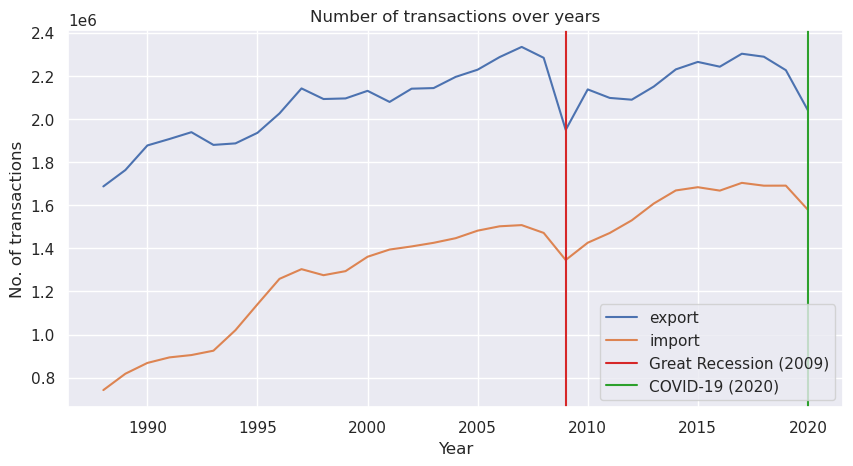

In [17]:
sns.lineplot(data=trans_year_pd, x='year', y='count', hue='exp_imp')
plt.xlabel('Year')
plt.ylabel('No. of transactions')
plt.title('Number of transactions over years')

plt.axvline(x=2009, color='tab:red', label='Great Recession (2009)')
plt.axvline(x=2020, color='tab:green', label='COVID-19 (2020)')
plt.legend()

<font color="blue">
    Number of transactions seems to increase per year. Export is always higher than import. <br>
    The affect of the Great Recession "resetted" the figures to almost 15 years backward. Export suffers more than import.
</font>

### What is the most popular category of product exported/imported from/to Japan?

In [18]:
fact_df\
    .where('exp_imp == "export"')\
    .withColumn('chapter', f.substring('hs6_code', 0, 2))\
    .join(section_chapter_df, on='chapter')\
    .groupby('section')\
    .count()\
    .orderBy('count')\
    .join(sec_df, on='section')\
    .select('name', 'count')\
    .show(5, truncate=False)

+-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+--------+
|name                                                                                                                                                                                                       |count   |
+-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+--------+
|Vehicles, aircraft, vessels and associated transport equipment                                                                                                                                             |4688399 |
|Plastics and articles thereof; rubber and articles thereof                                                                                 

In [19]:
fact_df\
    .where('exp_imp == "import"')\
    .withColumn('chapter', f.substring('hs6_code', 0, 2))\
    .join(section_chapter_df, on='chapter')\
    .groupby('section')\
    .count()\
    .orderBy('count')\
    .join(sec_df, on='section')\
    .select('name', 'count')\
    .show(5, truncate=False)

+-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+-------+
|name                                                                                                                                                                                                       |count  |
+-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+-------+
|Vehicles, aircraft, vessels and associated transport equipment                                                                                                                                             |1117210|
|Plastics and articles thereof; rubber and articles thereof                                                                                     

<font color="blue">
    The most popular exported product categories are identical with the import side, even the order of them are the same!!
</font>

### Does the most popular category of traded item change every year?

In [20]:
section_year_count = fact_df\
    .withColumn('chapter', f.substring('hs6_code', 0, 2))\
    .join(section_chapter_df, on='chapter')\
    .groupBy('year', 'section')\
    .count()

In [21]:
section_year_count\
    .groupBy('year')\
    .max('count')\
    .join(section_year_count.select('count', 'section'), on=f.col('max(count)') == f.col('count'))\
    .orderBy('year')\
    .show()

+----+----------+-------+-------+
|year|max(count)|  count|section|
+----+----------+-------+-------+
|1988|    781314| 781314|    XVI|
|1989|    826907| 826907|    XVI|
|1990|    882723| 882723|    XVI|
|1991|    898556| 898556|    XVI|
|1992|    903044| 903044|    XVI|
|1993|    883289| 883289|    XVI|
|1994|    907277| 907277|    XVI|
|1995|    948159| 948159|    XVI|
|1996|   1021453|1021453|    XVI|
|1997|   1081356|1081356|    XVI|
|1998|   1065713|1065713|    XVI|
|1999|   1055384|1055384|    XVI|
|2000|   1087657|1087657|    XVI|
|2001|   1071125|1071125|    XVI|
|2002|   1078474|1078474|    XVI|
|2003|   1077760|1077760|    XVI|
|2004|   1093721|1093721|    XVI|
|2005|   1114182|1114182|    XVI|
|2006|   1137223|1137223|    XVI|
|2007|   1148508|1148508|    XVI|
+----+----------+-------+-------+
only showing top 20 rows



<font color="blue">
    No, they stay the same for every year, although the number of transaction increased.
</font>

### Item category with highest trade value?

In [22]:
fact_df\
    .withColumn('chapter', f.substring('hs6_code', 0, 2))\
    .join(hs_df, f.col('chapter') == f.col('hscode'))\
    .groupBy('hscode', 'description')\
    .avg('value')\
    .orderBy(f.desc('avg(value)'))\
    .withColumn('avg(value)', f.round('avg(value)', 4))\
    .show(truncate=False)

+------+--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+-----------+
|hscode|description                                                                                                                                                                                                         |avg(value) |
+------+--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+-----------+
|27    |Mineral fuels, mineral oils and products of their distillation; bituminous substances; mineral waxes                                                                                                                |712175.7208|
|89    |Ships, boats and floating structures                    